# HW1

## Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

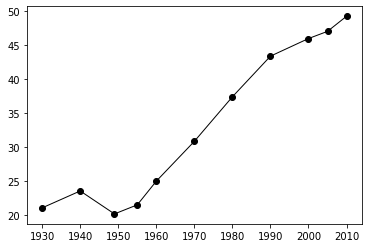

In [2]:
table = {"year": [1930, 1940, 1949, 1955, 1960, 1970, 1980, 1990, 2000, 2005, 2010],\
         "population": [21.058, 23.547, 20.167, 21.502, 24.989, 30.852, 37.407, 43.390, 45.985, 47.041, 49.268]}

fig, sub = plt.subplots(nrows = 1, ncols = 1)
sub.plot(table["year"], table["population"], c = "k", lw = 1, marker = "o")

## (a) Lagrange polynomial
### Use this polynomial to predict (extrapolate) the population at one year intervals up to 2020. Tabulate and plot the population prediction.

In [3]:
def lagrangePolynomial(xInter, xArray, yArray):
    yInter = np.full(len(xInter), np.nan, dtype = float)
    for xInd, x in enumerate(xInter):
        px = 0
        n = len(xArray)
        for j in range(n):
            yj = yArray[j]
            pi = 1.
            for i in range(n):
                if i == j:
                    continue
                else:
                    pi = pi * ((x - xArray[i]) / (xArray[j] - xArray[i]))
            px = px + (yj * pi)
        yInter[xInd] = px
    
    return yInter

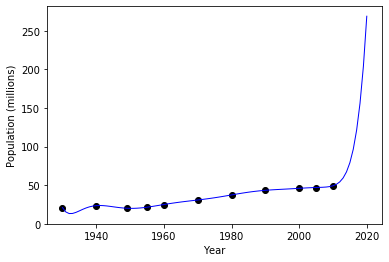

In [8]:
xInter = np.arange(1930, 2020 + 1, 1)
yInter = lagrangePolynomial(xInter, table["year"], table["population"])

fig, sub = plt.subplots(nrows = 1, ncols = 1)
sub.plot(table["year"], table["population"], c = "k", lw = 0, marker = "o")
sub.plot(xInter, yInter, c = "b", lw = 1)
sub.set_ylim(bottom = 0)
sub.set_xlabel("Year", fontsize = 10)
sub.set_ylabel("Population (millions)", fontsize = 10)

plt.savefig("./HW1/a.png", dpi = 500, bbox_inches = "tight")

In [6]:
df = pd.DataFrame(yInter, index = xInter, columns = ["Interpolated population"])
df.to_excel("./HW1/a.xlsx", float_format = "%.3f", header = True, index = True, index_label = "Year")

## (b) Drop 2010 data

At 2010, real population is 49, but interpolated population is 3.


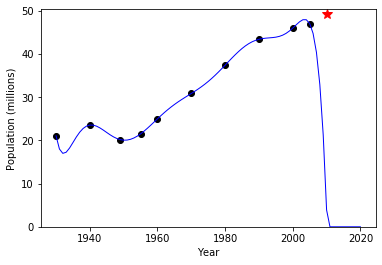

In [15]:
yInterDrop = lagrangePolynomial(xInter, table["year"][: -1], table["population"][: -1])
yInterDrop[yInterDrop < 0] = 0

fig, sub = plt.subplots(nrows = 1, ncols = 1)
sub.plot(table["year"][: -1], table["population"][: -1], c = "k", lw = 0, marker = "o")
sub.plot(xInter, yInterDrop, c = "b", lw = 1)
sub.set_ylim(bottom = 0)

sub.plot(table["year"][-1], table["population"][-1], c = "r", lw = 0, marker = "*", ms = 10)
real10 = table["population"][-1]
inter10 = yInterDrop[np.where(xInter == 2010)[0][0]]
sub.set_xlabel("Year", fontsize = 10)
sub.set_ylabel("Population (millions)", fontsize = 10)
print("At 2010, real population is %i, but interpolated population is %i." % (real10, inter10))

plt.savefig("./HW1/b.png", dpi = 500, bbox_inches = "tight")

In [13]:
df = pd.DataFrame(yInterDrop, index = xInter, columns = ["Interpolated population"])
df.to_excel("./HW1/b.xlsx", float_format = "%.3f", header = True, index = True, index_label = "Year")

## (c) Cubic spline
### Repeat parts (a) and (b) using a cubic spline with your own end condition. Discuss your results.

In [36]:
def delta(array, i):
    delta = array[i + 1] - array[i]
    
    return delta


def cubicSpline(endCondition, xInter, xArray, yArray):
    N = len(xArray) - 1
    
    matrix  = np.zeros((N - 1, N - 1), dtype = float)
    matrixF = np.full((N - 1, 1), np.nan, dtype = float)
    for i in np.arange(N - 1) + 1:
        ind = i - 1
        matrix[ind, ind] = (delta(xArray, i - 1) + delta(xArray, i)) / 3.
        
        if i == 1:
            matrix[ind, -1] = delta(xArray, i - 1) / 6.
        else:
            matrix[ind, ind - 1] = delta(xArray, i - 1) / 6.
        
        if i == N - 1:
            matrix[ind, 0] = delta(xArray, i) / 6.
        else:
            matrix[ind, ind + 1] = delta(xArray, i) / 6.
            
        matrixF[ind] = ((yArray[i + 1] - yArray[i]) / delta(xArray, i)) - ((yArray[i] - yArray[i - 1]) / delta(xArray, i - 1))
    
    matrixG = np.matmul(np.linalg.inv(matrix), matrixF)
    
    if endCondition == "free":
        matrixG = np.insert(matrixG, 0, 0)
        matrixG = np.append(matrixG, 0)
    
    elif endCondition == "periodic":
        matrixG = np.insert(matrixG, 0, matrixG[-1])
        matrixG = np.append(matrixG, matrixG[1])
    
    yInter = np.full(len(xInter), np.nan, dtype = float)
    
    for x, xx in enumerate(xInter):
        minInd = np.argmin(np.abs(xArray - xx))
        if xx < xArray[0]:
            ind = 0
        elif xx >= xArray[-1]:
            ind = N - 1
        else:
            ind = minInd if xx >= xArray[minInd] else minInd - 1
        
        first  = (matrixG[ind] / 6.) * ((((xArray[ind + 1] - xx) ** 3) / delta(xArray, ind)) - (delta(xArray, ind) * (xArray[ind + 1] - xx)))
        second = (matrixG[ind + 1] / 6.) * ((((xx - xArray[ind]) ** 3) / delta(xArray, ind)) - (delta(xArray, ind) * (xx - xArray[ind])))
        third  = yArray[ind] * (xArray[ind + 1] - xx) / delta(xArray, ind)
        fourth = yArray[ind + 1] * (xx - xArray[ind]) / delta(xArray, ind)
        yInter[x] = first + second + third + fourth
    
    return yInter

### Free end condition

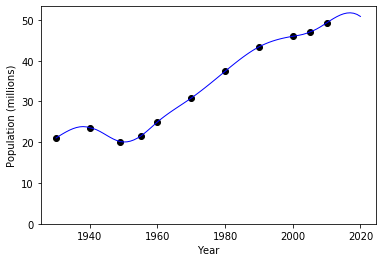

In [39]:
yInter = cubicSpline("free", xInter, table["year"], table["population"])

df = pd.DataFrame(yInter, index = xInter, columns = ["Interpolated population"])
df.to_excel("./HW1/c-free-1.xlsx", float_format = "%.3f", header = True, index = True, index_label = "Year")

fig, sub = plt.subplots(nrows = 1, ncols = 1)
sub.plot(table["year"], table["population"], c = "k", lw = 0, marker = "o")
sub.plot(xInter, yInter, c = "b", lw = 1)
sub.set_ylim(bottom = 0)
sub.set_xlabel("Year", fontsize = 10)
sub.set_ylabel("Population (millions)", fontsize = 10)

plt.savefig("./HW1/c-free-1.png", dpi = 500, bbox_inches = "tight")

At 2010, real population is 49, but interpolated population is 48.


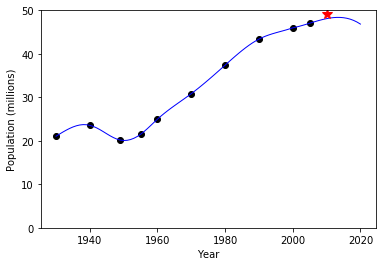

In [44]:
yInterDrop = cubicSpline("free", xInter, table["year"][: -1], table["population"][: -1])
yInterDrop[yInterDrop < 0] = 0

df = pd.DataFrame(yInterDrop, index = xInter, columns = ["Interpolated population"])
df.to_excel("./HW1/c-free-2.xlsx", float_format = "%.3f", header = True, index = True, index_label = "Year")

fig, sub = plt.subplots(nrows = 1, ncols = 1)
sub.plot(table["year"][: -1], table["population"][: -1], c = "k", lw = 0, marker = "o")
sub.plot(xInter, yInterDrop, c = "b", lw = 1)
sub.set_ylim(bottom = 0, top = 50)

sub.plot(table["year"][-1], table["population"][-1], c = "r", lw = 0, marker = "*", ms = 10)
real10 = table["population"][-1]
inter10 = yInterDrop[np.where(xInter == 2010)[0][0]]
sub.set_xlabel("Year", fontsize = 10)
sub.set_ylabel("Population (millions)", fontsize = 10)
print("At 2010, real population is %i, but interpolated population is %i." % (real10, inter10))

plt.savefig("./HW1/c-free-2.png", dpi = 500, bbox_inches = "tight")

### Periodic end condition

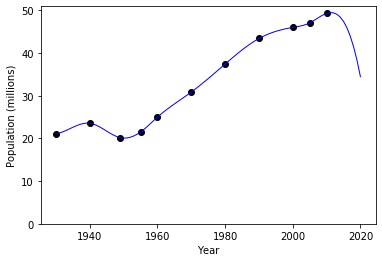

In [42]:
yInter = cubicSpline("periodic", xInter, table["year"], table["population"])

df = pd.DataFrame(yInter, index = xInter, columns = ["Interpolated population"])
df.to_excel("./HW1/c-periodic-1.xlsx", float_format = "%.3f", header = True, index = True, index_label = "Year")

fig, sub = plt.subplots(nrows = 1, ncols = 1)
sub.plot(table["year"], table["population"], c = "k", lw = 0, marker = "o")
sub.plot(xInter, yInter, c = "b", lw = 1)
sub.set_ylim(bottom = 0)
sub.set_xlabel("Year", fontsize = 10)
sub.set_ylabel("Population (millions)", fontsize = 10)

plt.savefig("./HW1/c-periodic-1.png", dpi = 500, bbox_inches = "tight")

At 2010, real population is 49, but interpolated population is 44.


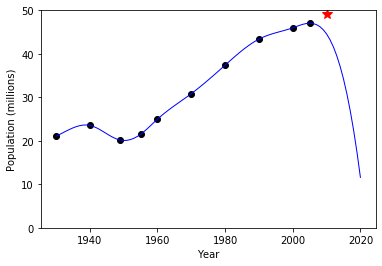

In [45]:
yInterDrop = cubicSpline("periodic", xInter, table["year"][: -1], table["population"][: -1])
yInterDrop[yInterDrop < 0] = 0

df = pd.DataFrame(yInterDrop, index = xInter, columns = ["Interpolated population"])
df.to_excel("./HW1/c-periodic-2.xlsx", float_format = "%.3f", header = True, index = True, index_label = "Year")

fig, sub = plt.subplots(nrows = 1, ncols = 1)
sub.plot(table["year"][: -1], table["population"][: -1], c = "k", lw = 0, marker = "o")
sub.plot(xInter, yInterDrop, c = "b", lw = 1)
sub.set_ylim(bottom = 0, top = 50)

sub.plot(table["year"][-1], table["population"][-1], c = "r", lw = 0, marker = "*", ms = 10)
real10 = table["population"][-1]
inter10 = yInterDrop[np.where(xInter == 2010)[0][0]]
sub.set_xlabel("Year", fontsize = 10)
sub.set_ylabel("Population (millions)", fontsize = 10)
print("At 2010, real population is %i, but interpolated population is %i." % (real10, inter10))

plt.savefig("./HW1/c-periodic-2.png", dpi = 500, bbox_inches = "tight")